In [9]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from datetime import datetime

from statsmodels.tsa.seasonal import MSTL, STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.naive import NaiveForecaster
from sktime.performance_metrics.forecasting import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sktime.forecasting.tbats import TBATS
from sktime.forecasting.base import ForecastingHorizon

from data_prepro import get_energy_data_today

In [2]:
df_energy = get_energy_data_today(to_date="20231220")
print(df_energy.info())
df_energy.tail(5)

c:\Users\ytl_c\OneDrive\Desktop\23_24 WS (Master)\VL - PTSFC\2023_11-PTSFC
68 NA in df
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 78603 entries, 2014-12-31 23:00:00+00:00 to 2023-12-20 01:00:00+00:00
Freq: H
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype              
---  ------         --------------  -----              
 0   gesamt         78603 non-null  float64            
 1   timestamp_CET  78603 non-null  datetime64[ns, CET]
 2   weekday        78603 non-null  int32              
dtypes: datetime64[ns, CET](1), float64(1), int32(1)
memory usage: 2.1 MB
None


,gesamt,timestamp_CET,weekday
timestamp_UTC,,,
2023-12-19 21:00:00+00:00,52819.25,2023-12-19 22:00:00+01:00,1
2023-12-19 22:00:00+00:00,49462.25,2023-12-19 23:00:00+01:00,1
2023-12-19 23:00:00+00:00,45810.25,2023-12-20 00:00:00+01:00,2
2023-12-20 00:00:00+00:00,43947.50,2023-12-20 01:00:00+01:00,2
2023-12-20 01:00:00+00:00,42793.75,2023-12-20 02:00:00+01:00,2


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 337 entries, 2023-12-06 01:00:00+00:00 to 2023-12-20 01:00:00+00:00
Freq: H
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   gesamt  337 non-null    float64
dtypes: float64(1)
memory usage: 5.3 KB


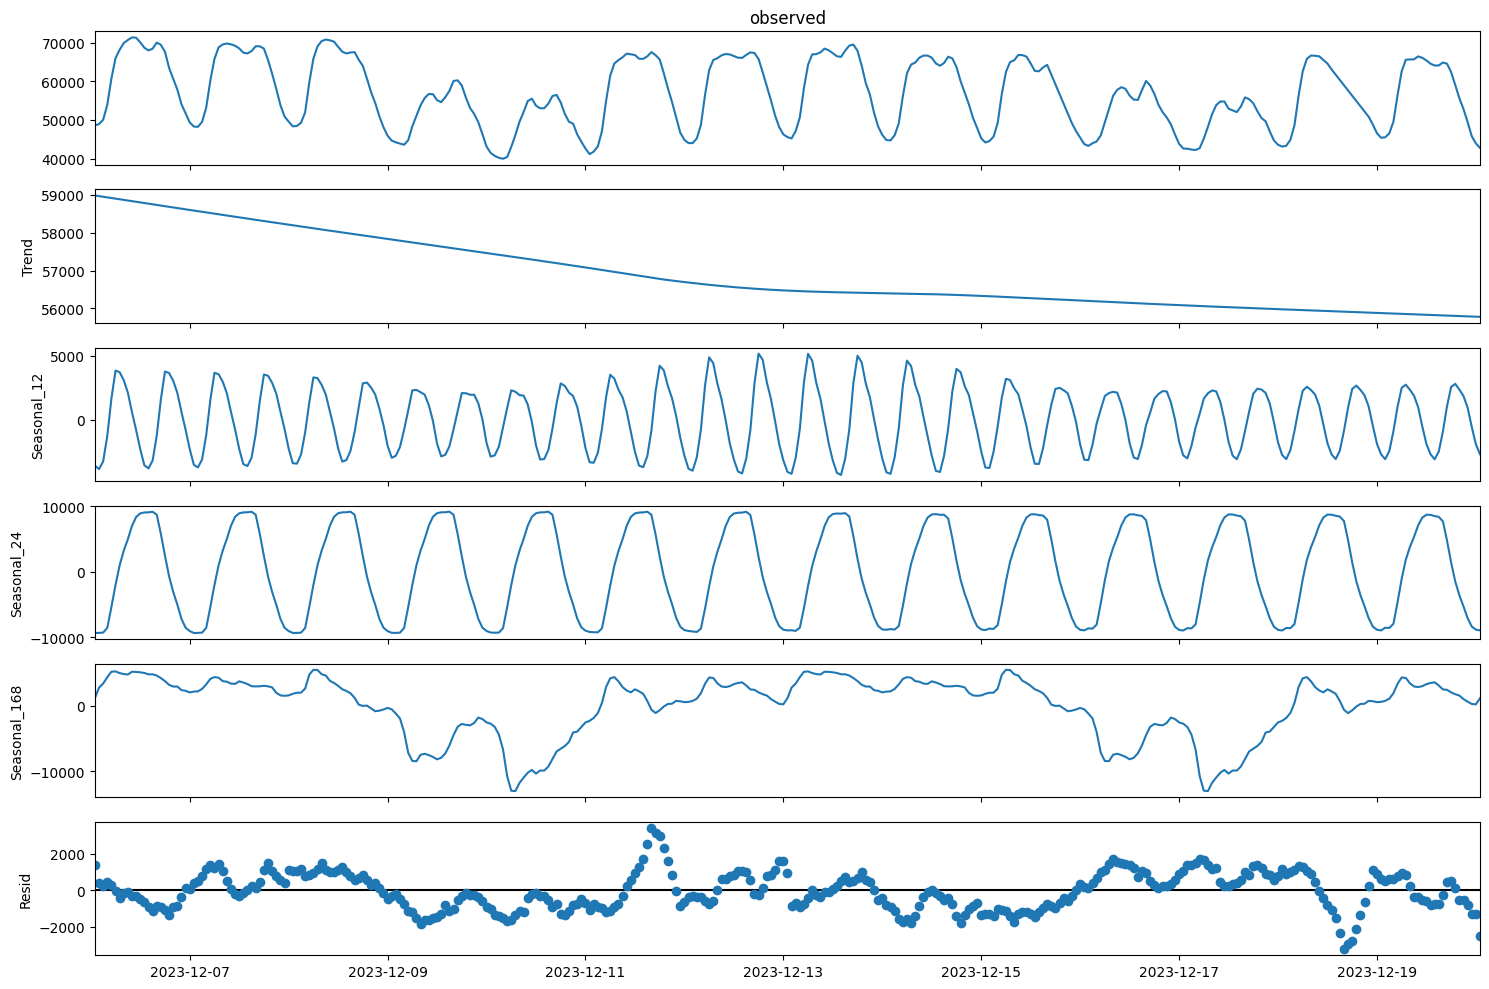

In [3]:
# take last n values only
n_last = 24*7*2 + 1
df_energy_small = df_energy.iloc[-n_last:][['gesamt']]

# take values from 2020-01-01 to 2023-01-01
# df_energy_small = df_energy.loc['2020-01-01':'2023-01-01'][['gesamt']]
df_energy_small.info()

mstl = MSTL(df_energy_small, periods=[12, 24, 24*7], iterate=1, 
            stl_kwargs={"seasonal_deg": 0,
                        "inner_iter": 2,
                        "outer_iter": 0})

res = mstl.fit()

plt.rc("figure", figsize=(15, 10))
plt.rc("font", size=10)

res.plot()
plt.tight_layout()
plt.show()

In [39]:
from tbats import TBATS

# = = = = = = = = = = = = = 
# Train Test Split

y = df_energy_small['gesamt']

test_perc = 0.1
test_size = np.floor(len(y)*test_perc).astype(int)

y_train, y_test = temporal_train_test_split(y, test_size=test_size)

# = = = = = = = = = = = = = 
# TBATS Forecasting Model

forecaster = TBATS(
    use_box_cox=True,
    use_trend=True,
    use_damped_trend=True,
    seasonal_periods=[24],
    use_arma_errors=True,
    n_jobs=1)

fitted_model = forecaster.fit(y_train)
print(fitted_model.summary())

y_pred = fitted_model.forecast(steps=test_size)

Use Box-Cox: True
Use trend: True
Use damped trend: True
Seasonal periods: [24.]
Seasonal harmonics [6]
ARMA errors (p, q): (0, 0)
Box-Cox Lambda 0.000000
Smoothing (Alpha): 1.542835
Trend (Beta): -0.042359
Damping Parameter (Phi): 0.982919
Seasonal Parameters (Gamma): [-2.60686192e-07 -5.09240004e-07]
AR coefficients []
MA coefficients []
Seed vector [ 1.10937320e+01 -3.62100908e-03 -1.76457296e-01 -6.79383375e-02
  6.36232705e-03 -8.98698418e-04  4.89197992e-03  1.47140603e-03
 -5.68786644e-03 -1.24309371e-02 -1.04175241e-02 -1.02130197e-02
  5.65566066e-03  3.43022504e-03]

AIC 5929.699081


In [40]:
# Time series analysis
# print(fitted_model.y_hat) # in sample prediction
# print(fitted_model.resid) # in sample residuals
# print(fitted_model.aic)

# Reading model parameters
# print(fitted_model.params.alpha)
# print(fitted_model.params.beta)
# print(fitted_model.params.x0)
# print(fitted_model.params.components.use_box_cox)
# print(fitted_model.params.components.seasonal_harmonics)

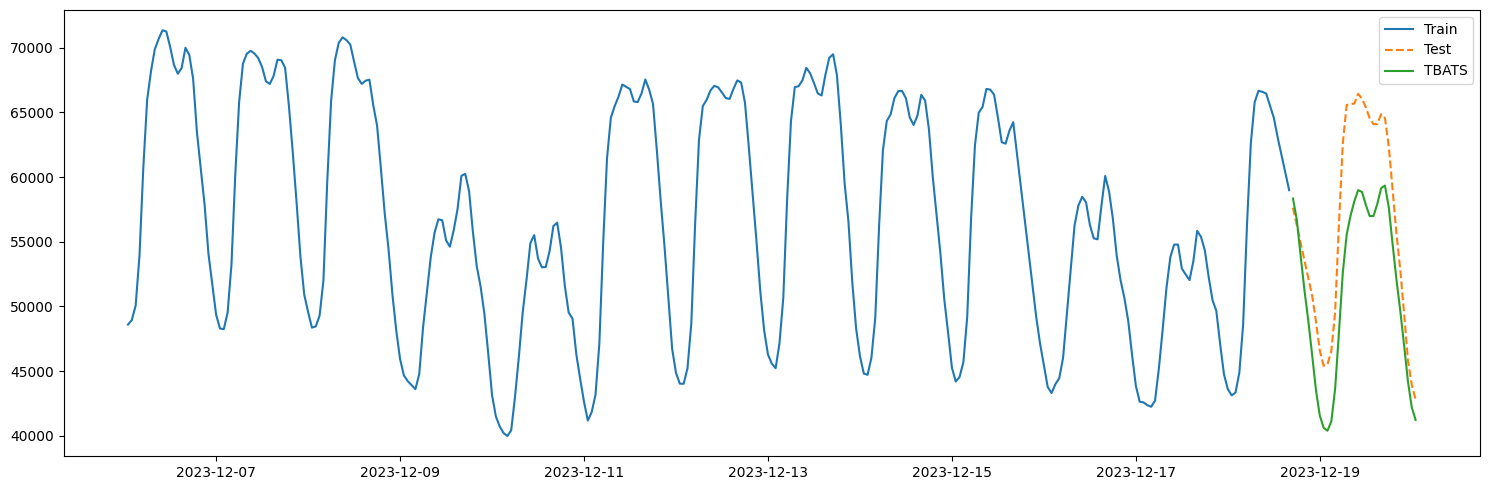

In [42]:
plt.figure(figsize=(15, 5))

plt.plot(y_train, label='Train')
plt.plot(y_test, ls='--', label='Test')
plt.plot(y_test.index, y_pred, label='TBATS')

plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
import holidays
bw_holidays = holidays.DE(prov='BW')

In [ ]:
# get national holidays in germany
# make dummy variables in dataframe for each holiday
# regress on dummy variables and seasonal components as described in De Livera, Hyndman, Snyder paper
# obtain estimated effect of holidays which we can now remove from the series
# do one more MSTL on the series without holiday effects